# Анализ убытков развлекательного приложения

**Цель проекта:** найти причины неокупаемости рекламы и помощь компании стать прибыльной

**Описание данных:**

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

**План работы:**
1. Выгрузка необходимых данных
2. Предобработка данных
3. Создание функций для создания пользовательских профилей, для расчёта удержания, для расчета конверсии, для расчета LTV, ROI, для визуализации конверсии, удержания, LTV и ROI
4. Построение профилей пользователей
5. Анализ пользователей приложения
6. Анализ расходов на рекламу
7. Анализ окупаемости рекламы для привлечения пользователей
8. Написание общих выводов

<div style="border-radius: 15px; border: 3px solid Black; padding: 15px;">
    <b> Оглавление </b>
    
1. [Загрузка и подготовка данных к исследованию](#step1)
2. [Функции для расчета и анализа LTV, ROI, удержания и конверсии](#step2)
3. [Исследовательский анализ данных](#step3)
4. [Анализ расходов на рекламу](#step4)
5. [Оценка окупаемости рекламы для привлечения пользователей](#step5)
6. [Общие выводы](#step6)

<a id="step1"></a>
## 1. Загрузка и подготовка данных к исследованию

Импортируем необходимые библиотеки

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

Загружаем данные о визитах, заказах и расходах в переменные

In [2]:
try:
    visits, orders, costs = (
    pd.read_csv('U:/visits_info_short.csv'),  # журнал сессий
    pd.read_csv('U:/orders_info_short.csv'),  # покупки
    pd.read_csv('U:/costs_info_short.csv'), # траты на рекламу
    )
except FileNotFoundError:
    print('Ошибка загрузки данных')

Проверим тип данных в датасетах

In [3]:
# проверка типов данных
print(visits.dtypes),
print(''),
print(orders.dtypes),
print(''),
print(costs.dtypes)

User Id           int64
Region           object
Device           object
Channel          object
Session Start    object
Session End      object
dtype: object

User Id       int64
Event Dt     object
Revenue     float64
dtype: object

dt          object
Channel     object
costs      float64
dtype: object


Проверим наличие пропущенных значений в датасетах

In [4]:
visits.isnull().sum()
orders.isnull().sum()
costs.isnull().sum()

dt         0
Channel    0
costs      0
dtype: int64

Выведем таблицы на экран

In [5]:
display(visits.head(1))
display(orders.head(1))
display(costs.head(1))

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3


Сделаем наименования столбцов датасетов более корректными

In [6]:
# переименуем столбцы таблицы visits
visits.columns = visits.columns.str.lower().str.replace(' ', '_')
display(visits.head(0))

# переименуем столбцы таблицы orders
orders.columns = orders.columns.str.lower().str.replace(' ', '_')
display(orders.head(0))

# переименуем столбцы таблицы costs
costs.columns = costs.columns.str.lower()
display(costs.head(0))

,user_id,region,device,channel,session_start,session_end


,user_id,event_dt,revenue


,dt,channel,costs


Преобразуем данные о времени в датасетах

In [7]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

Найдем min и max даты в столбце с началом сессии в таблице session

In [8]:
min_date = visits['session_start'].min().date()
max_date = visits['session_start'].max().date()
print('Минимальная дата предоставленных данных:', min_date)
print('Максимальная дата предоставленных данных:', max_date)

Минимальная дата предоставленных данных: 2019-05-01
Максимальная дата предоставленных данных: 2019-10-31


Найдем min и max даты в столбце с окончанием сессии в таблице session

In [9]:
min_date = visits['session_end'].min().date()
max_date = visits['session_end'].max().date()
print('Минимальная дата предоставленных данных:', min_date)
print('Максимальная дата предоставленных данных:', max_date)

Минимальная дата предоставленных данных: 2019-05-01
Максимальная дата предоставленных данных: 2019-11-01


Найдем min и max в столбце с датой в таблице costs

In [10]:
min_date = costs['dt'].min()
max_date = costs['dt'].max()
print('Минимальная дата предоставленных данных:', min_date)
print('Максимальная дата предоставленных данных:', max_date)

Минимальная дата предоставленных данных: 2019-05-01
Максимальная дата предоставленных данных: 2019-10-27


Найдем min и max в столбце с датой в таблице orders

In [11]:
min_date = orders['event_dt'].min().date()
max_date = orders['event_dt'].max().date()
print('Минимальная дата предоставленных данных:', min_date)
print('Максимальная дата предоставленных данных:', max_date)

Минимальная дата предоставленных данных: 2019-05-01
Максимальная дата предоставленных данных: 2019-10-31


Проверим корректность отражения дат по сессиям (дата начала сессии должна быть ранее даты окончания сессии)

In [12]:
visits[visits['session_start']>visits['session_end']]

,user_id,region,device,channel,session_start,session_end


Проверим корректность числовых данных в датасетах (проверим, что нет записей, где данные в столбцах с числовыми данными меньше 0)

In [13]:
print("Количество записей таблицы orders, где revenue <= 0:", orders['revenue'][orders['revenue'] <= 0].count())
print("Количество записей таблицы costs, где costs <= 0:", costs['costs'][costs['costs'] <= 0].count())

Количество записей таблицы orders, где revenue <= 0: 0
Количество записей таблицы costs, где costs <= 0: 0


Проверим отсутствие дубликатов в датасетах

In [14]:
print('Количество дублированных строк в таблице visits:',visits.duplicated().sum())
print()
print('Количество дублированных строк в таблице orders:',orders.duplicated().sum())
print()
print('Количество дублированных строк в таблице costs:',costs.duplicated().sum())

Количество дублированных строк в таблице visits: 0

Количество дублированных строк в таблице orders: 0

Количество дублированных строк в таблице costs: 0


**Вывод**
- Исходные данные были предоставлены по сессиям, начатые в период с 1 мая 2019 год по 31 октября 2019 год.
- Дата начала сессии в таблице session идет раньше даты окончания сессии в таблице session, значит данные по датам в таблице session предоставлены корректо.
- Период проведения рекламной кампании в таблице costs - c 01.05.2019 по 27.10.2019, что соответствует периоду с 1 мая 2019 год по 31 октября 2019 год, значит данные по датам в таблице корректны.
- Период осуществления расходов пользователями приложения в таблице orders - с 01.05.2019 по 31.10.2019, что соответствует периоду сессий, значит данные предоставлены корректно.
- В таблице costs все расходы на рекламную кампанию больше 0, значит данные по расходам в таблице costs корректны.
- В таблице orders все суммы заказов больше 0, значит данные по стоимости заказов в таблице orders корректны.
- Во всех предоставленных датафреймах нет пропущенных значений, значит анализ данных будет максимально корректным.
- Во всех предоставленных датафреймах нет дубликатов.
- Изначально были предоставлены стилистически некорректные наименования столбцов (верхние регистры и пробелы) - были исправлены наименования столбцов.
- Изначально во всех датафреймах был задан некорректный тип данных по столбцам с датами - исправлено на корректный

<a id="step2"></a>
## 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

Функция для создания пользовательских профилей

In [15]:
def get_profiles(sessions, orders, costs, event_names=[]):
    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    
    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    
    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())
    
    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    
    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    
    # объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    
    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']
    
    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)
    return profiles

Функция для расчёта удержания

In [16]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions
    
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days
    
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для расчёта конверсии

In [17]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )
    
    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']
        
    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result
    
    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    
    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []
        
    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

Функция для расчёта LTV и ROI

In [18]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):
    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']
        
    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes
        
        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        
        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        
        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)
        
        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        
        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes
        
        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']
        
        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        
        # возвращаем таблицы LTV и ROI
        return result, roi
    
    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    
    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []
        
    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )
    
    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функция для сглаживания фрейма

In [19]:
def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

Функция для визуализации удержания

In [20]:
def plot_retention(retention, retention_history, horizon, window=7):
    
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))
    
    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    
    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])
        
    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')
    
    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')
    
    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

Функция для визуализации конверсии

In [21]:
def plot_conversion(conversion, conversion_history, horizon, window=7):
    
    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))
    
    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]
    
    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')
    
    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show() 

Функция для визуализации LTV и ROI

In [22]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):
    
    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))
    
    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]
    
    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]
    
    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]
    
    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')
    
    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))
    
    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')
    
    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')
    
    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))
    
    plt.tight_layout()
    plt.show() 

<a id="step3"></a>
## 3. Исследовательский анализ данных

### 3.1 Построение профилей пользователей

Построим профили пользователей

In [23]:
profiles = get_profiles(visits, orders, costs)
display(profiles.head(5)) 

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


Определим минимальную и максимальную дату привлечения пользователей

In [24]:
min_date = profiles['first_ts'].min().date()
max_date = profiles['first_ts'].max().date()
print('Минимальная дата привлечения пользователей:', min_date)
print('Максимальная дата привлечения пользователей:', max_date)

Минимальная дата привлечения пользователей: 2019-05-01
Максимальная дата привлечения пользователей: 2019-10-27


***Вывод***
- Согласно таблице, у нас сейчас имеются данные с 1 мая 2019 по 27 октября 2019, что соответствует ТЗ, т.е. нет никаких выбивающихся данных.
- ТЗ были заданы такие данные, поскольку изначально имелись данные о рекламных кампаний, проведенных в период с 1 мая 2019 по 27 октября 2019.

### 3.2 Определение стран, из которых пользователи приходят в приложение, и на которых приходится больше всего платящих пользователей.

Создадим таблицу для пострения диаграммы рапределения количества платящих пользователей в % по странам в порядке убывания

In [25]:
tab_region = (profiles.groupby('region')
      .agg({'user_id':'nunique','payer':'sum'}))
tab_region['perc'] = round((tab_region['payer']/tab_region['user_id']* 100), 2)
tab_region.sort_values(by = 'perc', ascending = False)

,user_id,payer,perc
region,,,
United States,100002,6902,6.90
Germany,14981,616,4.11
UK,17575,700,3.98
France,17450,663,3.80


Построим диаграмму рапределения количества платящих пользователей в % по странам в порядке убывания

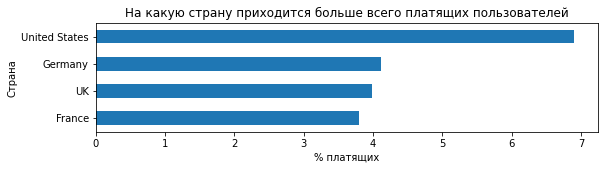

In [26]:
(tab_region.pivot_table(index = 'region', values = 'perc').sort_values(by = 'perc')
   .plot(kind = 'barh', figsize=(9,2),title = 'На какую страну приходится больше всего платящих пользователей', legend = False)
    .set(xlabel = '% платящих',ylabel = 'Страна'));

***Вывод***
- Пользователи приходят в приложение из США, Германии, Англии и Франции.
- На США приходится больше всего платящих пользователей, т.е. потенциально выручка больше может быть именно оттуда.

### 3.3 Определение видов устройств, которыми пользуются клиенты и которые предпочитают платящие пользователи

Создадим таблицу для построения диаграммы распределения количества платящих пользователей в % по устройствам

In [27]:
tab_device = (profiles.groupby('device')
      .agg({'user_id':'nunique','payer':'sum'}))
tab_device['perc'] = round((tab_device['payer']/tab_device['user_id']* 100), 2)
tab_device.sort_values(by = 'perc', ascending = False)

,user_id,payer,perc
device,,,
Mac,30042,1912,6.36
iPhone,54479,3382,6.21
Android,35032,2050,5.85
PC,30455,1537,5.05


Построим диаграмму распределения количества платящих пользователей в % по устройствам

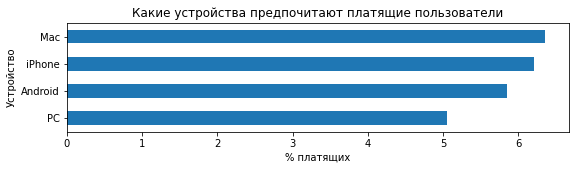

In [28]:
(tab_device.pivot_table(index = 'device', values = 'perc').sort_values(by = 'perc')
   .plot(kind = 'barh', figsize=(9,2),title = 'Какие устройства предпочитают платящие пользователи', legend = False)
    .set(xlabel = '% платящих',ylabel = 'Устройство'));

***Вывод***
- Клиенты пользуются компьютерам (Mac и PC) и телефонами (iPhone и Android).
- Платящие пользователи предпочитают в большей степени Mac, а в меньшей - PC

### 3.4 Определение каналов, из которых пришло больше всего платящих пользователей

Создадим таблицу для построения диаграммы распределения количества платящих пользователей в % по каналам привлечения

In [29]:
tab_channel = (profiles.groupby('channel')
      .agg({'user_id':'nunique','payer':'sum'}))
tab_channel['perc'] = round((tab_channel['payer']/tab_channel['user_id']* 100), 2)
tab_channel.sort_values(by = 'perc', ascending = False)

,user_id,payer,perc
channel,,,
FaceBoom,29144,3557,12.20
AdNonSense,3880,440,11.34
lambdaMediaAds,2149,225,10.47
TipTop,19561,1878,9.60
RocketSuperAds,4448,352,7.91
WahooNetBanner,8553,453,5.30
YRabbit,4312,165,3.83
MediaTornado,4364,156,3.57
LeapBob,8553,262,3.06


Построим диаграмму распределения количества платящих пользователей в % по каналам привлечения

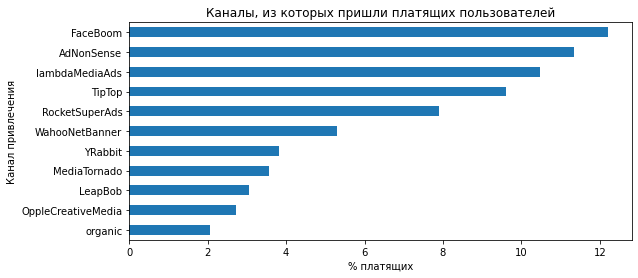

In [30]:
(tab_channel.pivot_table(index = 'channel', values = 'perc').sort_values(by = 'perc')
   .plot(kind = 'barh', figsize=(9,4),title = 'Каналы, из которых пришли платящих пользователей', legend = False)
    .set(xlabel = '% платящих',ylabel = 'Канал привлечения'));

**Вывод**
- Больше всего платящих пользователей пришло из FaceBoom. Также многие пришли из AdNonSense, lambdaMediaAds и TipTop.

### 3.5 Общий вывод

- Больше всего платящих пользователей из США, которые пользуется Mac и которые пришли из FaceBoom.

<a id="step4"></a>
## 4. Анализ расходов на рекламу

### 4.1. Определение общей суммы расходов на маркетинг 

In [31]:
print('Всего потратили на маркетинг:',round(profiles['acquisition_cost'].sum()))

Всего потратили на маркетинг: 105497


### 4.2 Определение того, как распределены расходы на рекламную компанию по каналам привлечения  

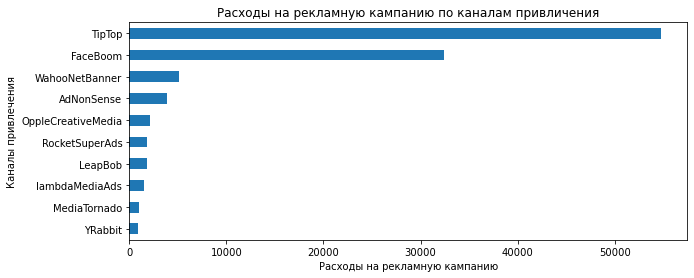

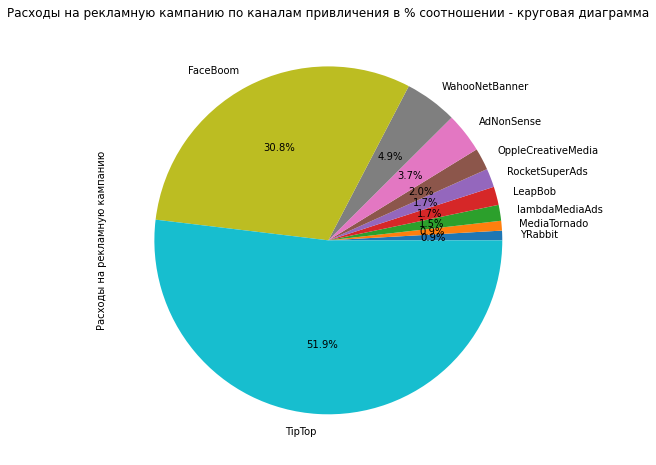

In [32]:
# столбчатая диаграмма

(profiles.query('acquisition_cost != 0')
.groupby('channel')['acquisition_cost']
.sum().sort_values(ascending = True).plot(kind = 'barh', figsize = (10,4)))

plt.ylabel('Каналы привлечения')
plt.xlabel('Расходы на рекламную кампанию')
plt.title('Расходы на рекламную кампанию по каналам привличения')
plt.show();

# круговая диаграмма

(profiles.query('acquisition_cost != 0')
.groupby('channel')['acquisition_cost']
.sum().sort_values(ascending = True).plot(kind = 'pie', figsize = (15,8), autopct='%1.1f%%'))
plt.title('Расходы на рекламную кампанию по каналам привличения в % соотношении - круговая диаграмма')
plt.ylabel('Расходы на рекламную кампанию')
plt.show(); 

***Вывод***
- Больше всего расходов (82%) было задейственно на рекламу в TipTop и FaceBoom.

### 4.3 Определение того, как распределены расходы на рекламную компанию по периодам

Создадим столбец с названием месяца для построения графиков распределения количества расходов на рекламную компанию по периодам

In [33]:
# создание столбца с названием месяца

profiles['month_name'] = profiles['month'].dt.month
def name_month (row):
    if row['month_name'] == 5:
        return 'май'
    elif row['month_name'] == 6:
        return 'июнь'
    elif row['month_name'] == 7:
        return 'июль'
    elif row['month_name'] == 8:
        return 'август'
    elif row['month_name'] == 9:
        return 'сентябрь'
    else:
        return 'октябрь'
    
profiles['month_name'] = profiles.apply(name_month, axis = 1)

Построим диграмму распределения расходов на рекламу по периодам и график изменения расходов на рекламную кампанию по времени

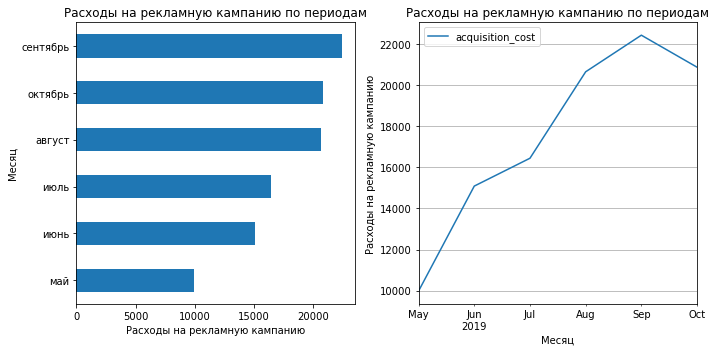

In [34]:
# даиграмма распределения расходов на рекламную кампанию по периодам (столбчатая даиграмма)

(profiles
.groupby('month_name')['acquisition_cost'].sum()
.sort_values(ascending = True).plot(kind = 'barh', figsize = (9,4), ax=plt.subplot(1, 2, 1)))
plt.ylabel('Месяц')
plt.xlabel('Расходы на рекламную кампанию')
plt.title('Расходы на рекламную кампанию по периодам');

# график изменения расходов на рекламную кампанию по времени 

profiles.pivot_table(
    index='month', values='acquisition_cost', aggfunc='sum'
).plot(grid=True, figsize=(10, 5), ax=plt.subplot(1, 2, 2))
plt.ylabel('Расходы на рекламную кампанию')
plt.xlabel('Месяц')
plt.title('Расходы на рекламную кампанию по периодам')

plt.tight_layout()
plt.show();

**Вывод**
- С мая по сентбярь расходы на рекламу росли, после - начали снижаться. Таким образом получается, что если у компании имеются проблемы, то скорее всего это связано в том числе с выбором не тех каналов привлечения клиентов в приложение.

### 4.4 Определение того, как меняются расходы на рекламную компанию на привлечение одного покупателя (CAC) по каналам привлечения и по периоду

Построим график динамики стоимости привлечения одного пользователя по каналам привлечения

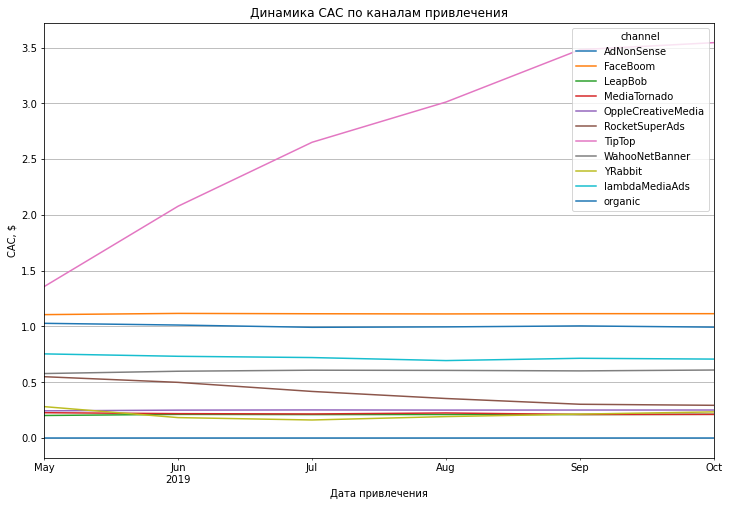

In [35]:
(profiles
       .pivot_table(index = 'month', columns \
                    = 'channel', values = 'acquisition_cost', aggfunc = 'mean')
        .plot(figsize=(12,8), grid = True));
plt.ylabel('CAC, $')
plt.xlabel('Дата привлечения')
plt.title('Динамика САС по каналам привлечения')
plt.show()

**Вывод**
- С мая по октябрь расходы существенно росли на канал привлечения TipTop. Данный рост повторяет рост всех расходов на рекламу. Возможно, компании стоит отказаться от привлечения клиентов через канал TipTop.

### 4.5 Определение средней суммы расходов на привлечение одного пользователя по каналам привлечения

Создадим таблицы для построения диаграммы распределения средней суммы расходов на привлечение одного пользователя по каналам привлечения

In [36]:
tab_per_user_channel = (profiles.query('acquisition_cost != 0').groupby('channel')
      .agg({'acquisition_cost':'sum', 'user_id':'nunique'}))
tab_per_user_channel['acquisition_cost'] \
= round(tab_per_user_channel['acquisition_cost'].astype('int'))
tab_per_user_channel['acquisition_cost_per_user'] \
= round((tab_per_user_channel['acquisition_cost']\
                                            /tab_per_user_channel['user_id']), 2)
#tab_per_user.dropna()
tab_per_user_channel['acquisition_cost_per_user'].sort_values(ascending = False)

channel
TipTop                2.80
FaceBoom              1.11
AdNonSense            1.01
lambdaMediaAds        0.72
WahooNetBanner        0.60
RocketSuperAds        0.41
OppleCreativeMedia    0.25
MediaTornado          0.22
YRabbit               0.22
LeapBob               0.21
Name: acquisition_cost_per_user, dtype: float64

Построим диаграмму распределения средней суммы расходов на привлечение одного пользователя по каналам привлечения

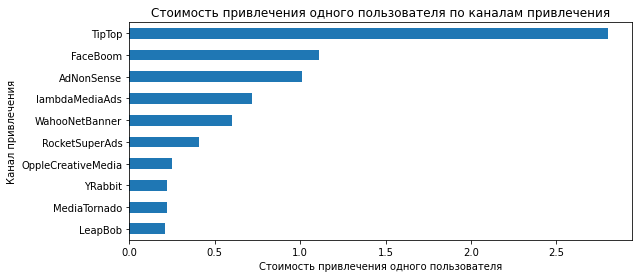

In [37]:
(tab_per_user_channel
 .pivot_table(index = 'channel', values = 'acquisition_cost_per_user')
 .sort_values(by = 'acquisition_cost_per_user')
   .plot(kind = 'barh', figsize=(9,4)\
         ,title = 'Стоимость привлечения одного пользователя по каналам привлечения'\
         , legend = False)
    .set(xlabel = 'Стоимость привлечения одного пользователя'\
         ,ylabel = 'Канал привлечения'));

Определим средний CAC на одного пользователя в общем

In [38]:
average_per_user = round((tab_per_user_channel['acquisition_cost_per_user'].mean()), 2)
print('Cредний CAC на одного пользователя для всего проекта:',average_per_user)

Cредний CAC на одного пользователя для всего проекта: 0.75


**Вывод**
- Дороже всего стоило привлечение одного клиента через канал TipTop. Самые дорогие источники привлечения одного клиента - TipTop, FaceBoom и AdNonSense.

<a id="step5"></a>
## 5. Оценка окупаемости рекламы для привлечения пользователей

Установим момент и горизонт анализа данных

In [39]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14 

### 5.1 Анализ общей окупаемости рекламы (CAC, LTV, ROI)

Из расчетов исключаем пользователей с органическим трафиком, поскольку мы за них ничего не платим, а нам нужно изучить именно окупаемость рекламы.

In [40]:
profiles = profiles.query('channel != "organic"')

Считаем LTV и ROI и построим графики

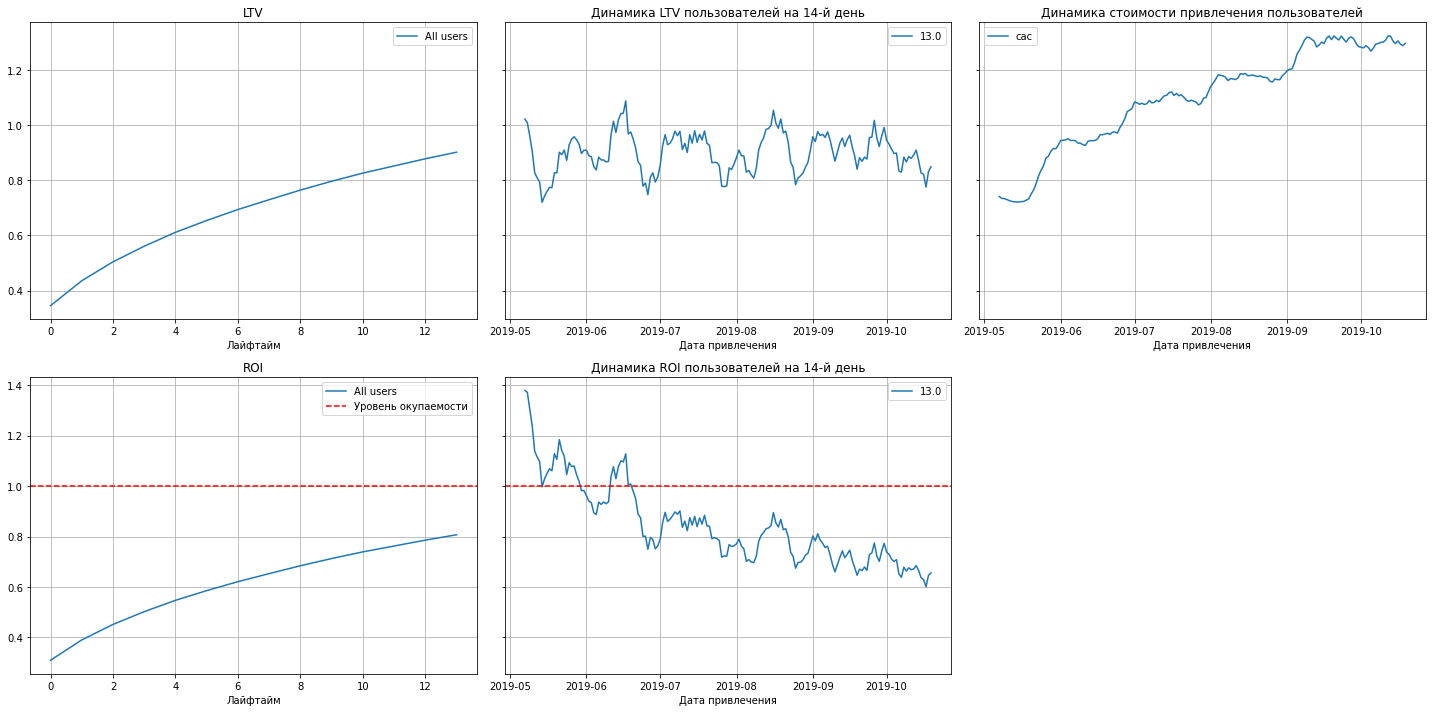

In [41]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Наблюдаем, что динамика ROI за лайфтайм падает. При относительно стабильной динамике LTV, динамика САС растёт с мая по конец октября. Эту закономерность мы наблюдаем в динамике ROI, что при сильном увеличении САС, в равной степени падает динамика ROI пользователей.

**Вывод**
- реклама, направленная на привлечение пользователей в целом, не окупается (окупаемость - 80%)
- расходы на рекламу растут более быстрыми темпами, чем выручка.
- CAC не стабилен, поэтому проблемы в том числе с увеличении рекламного бюджета.

### 5.2. Анализ окупаемости рекламы с разбивкой по рекламным каналам (CAC, LTV, ROI)

Посмотрим окупаемость рекламы с разбивкой по источникам привлечения, построим графики динамики CAC, LTV, ROI

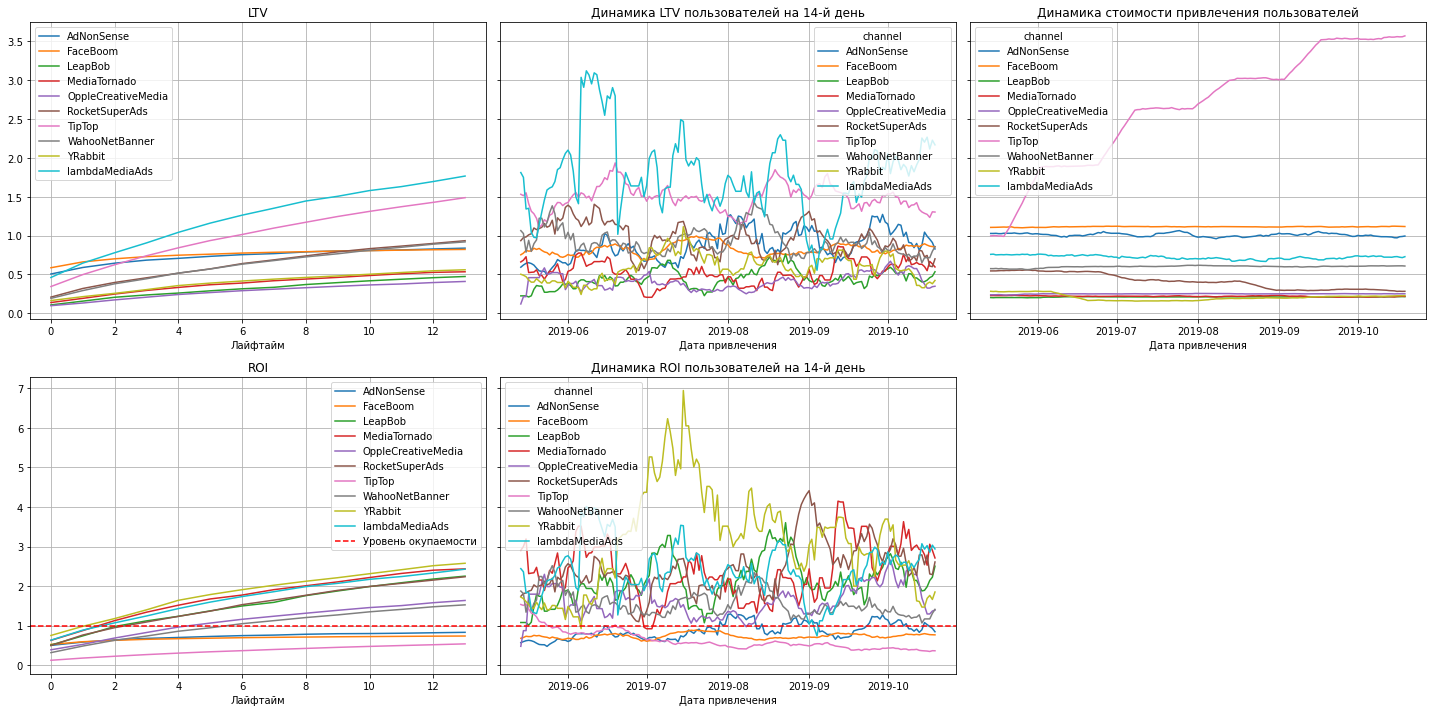

In [42]:
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14
) 

***Вывод***
- самые дорогие источники привлечения потенциальных пользователей за все время не смогли окупиться - TipTop, FaceBoom и AdNonSense. Все остальные источники привлечения, по которым стоимость привлечения пользователя ниже среднего, окупились.
- больше всего выручки приносит канал lambdaMediaAds, затем идет Tiptop
- лучше всего окупился канал YRabbit за счет того, что расходы по нему одни из самых небольших.
- стоимость привлечения новых пользователей по каналу TipTop постоянно растет и значительно превышает стоимость привлечения по другим каналам.
- окупаемость 14-го дня была самая высокая у канала YRabbit по пользователям, пришедших в приложение в июле.

### 5.3. Анализ окупаемости рекламы с разбивкой по странам (CAC, LTV, ROI)

Посмотрим окупаемость с разбивкой по странам, построим графики динамики CAC, ROI и LTV

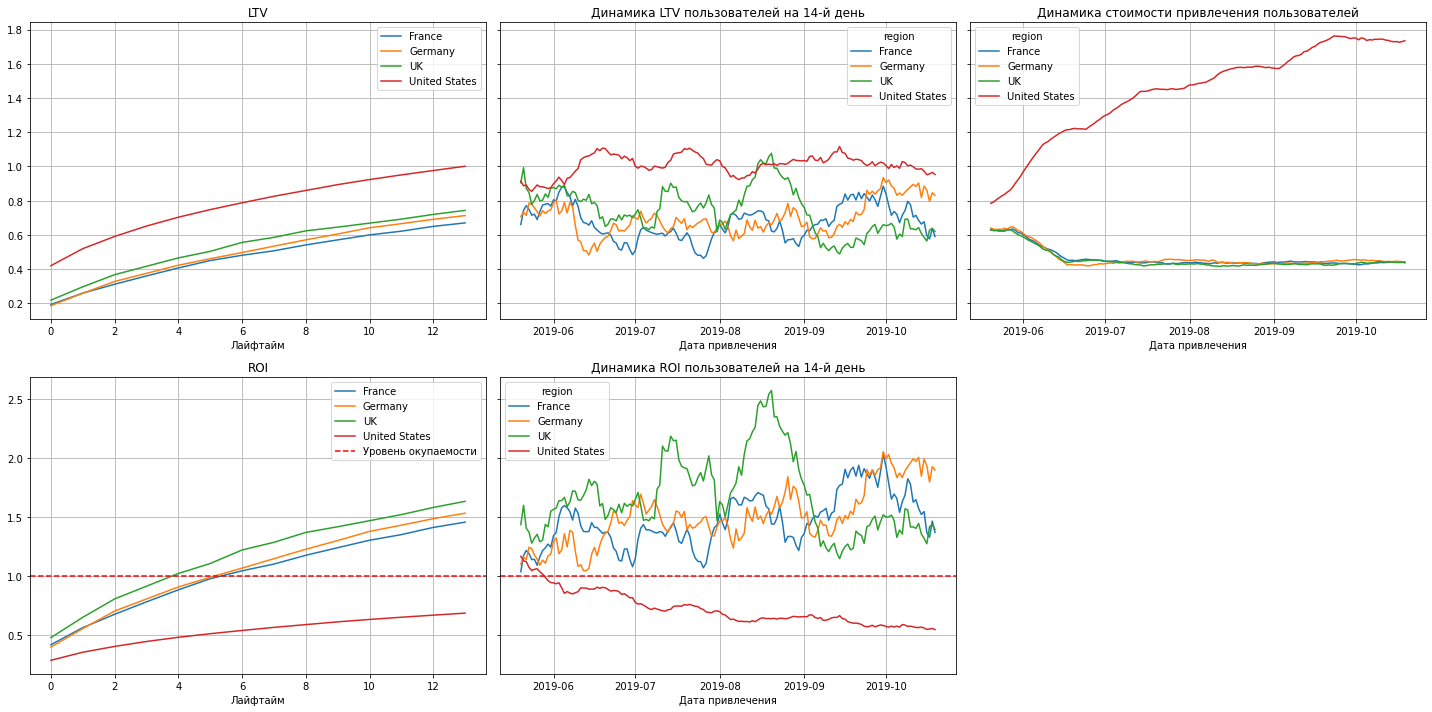

In [43]:
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20
) 

**Вывод**
- реклама окупается везде, кроме США (на 14 день жизни пользователя приложения окупаемость - 70%). Реклама у них окупилась на 3-4 день жизни пользователя. Лучше всего релкама окупается в Великобритании.
- расходы на рекламу сильно растут в США, в других странах начиная в июне они уменьшились на 0,2.
- больше всего выручки приносят пользователи из США, меньше всего - из Франции.

Рассмотрим детальнее окупаемость рекламы в США, построим графики динамики CAC, ROI и LTV

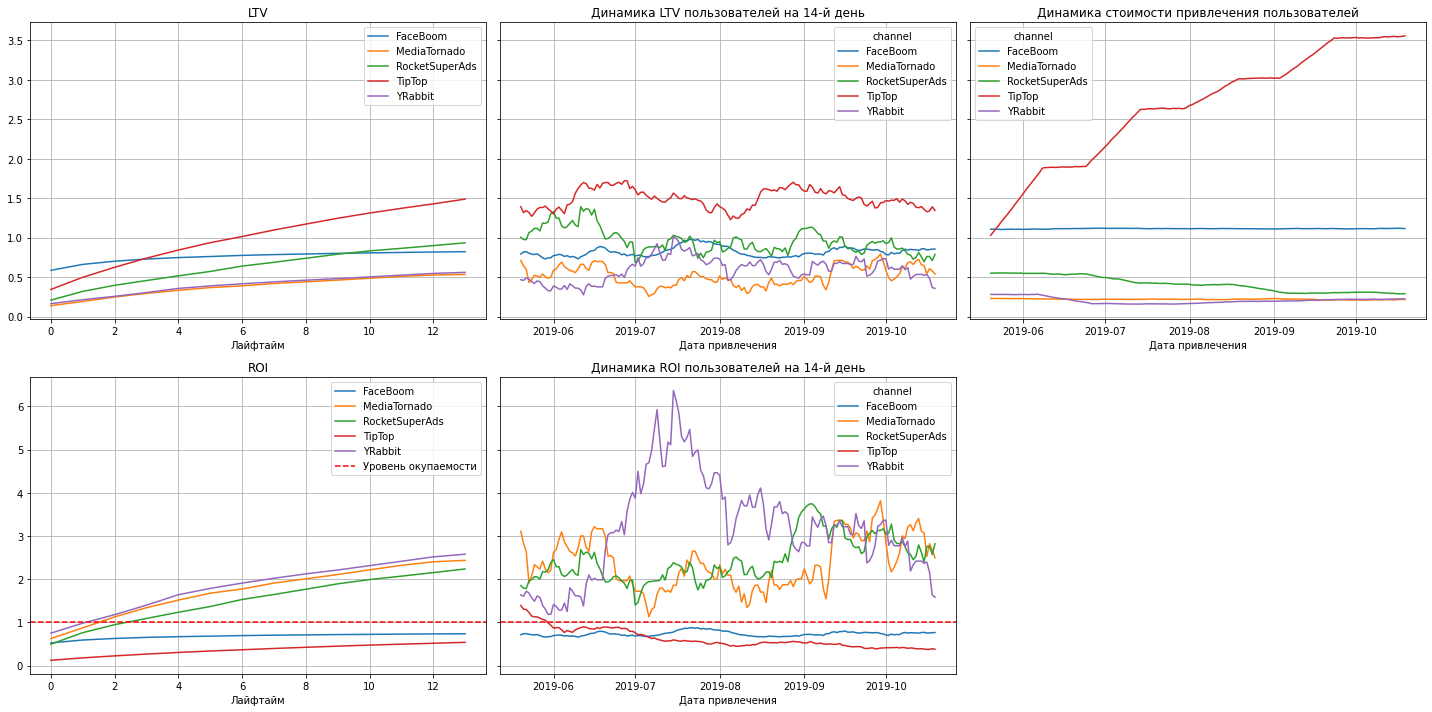

In [44]:
profiles1 = profiles.query('region == "United States"')

dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles1, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=20
) 

**Вывод**
- На привлечение пользователей из США большая часть расходов идет на канал TipTop, который не окупается. Если смотреть на вырычку, то не сильно выше доходы по данному каналу, чем остальные. Стоит обратить внимание на канал RocketSuperAds, который занимает 2 место по доходам, который окупается и по которому выручка доходы увеливаются при уменьшении расходов.

### 5.4 Анализ окупаемости рекламы с разбивкой по устройствам (конверсия и удержание)

**Конверсия**

Построим графики динамики конверсии пользователей по устройствам и динамики конверсии пользователей на 14-й день

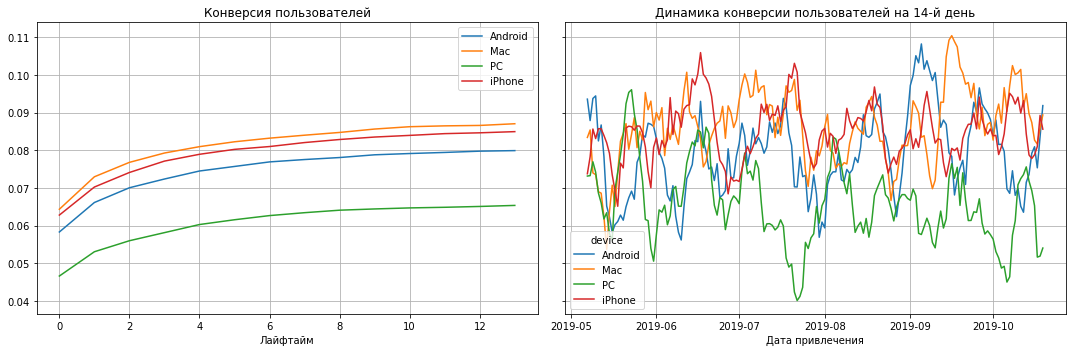

In [45]:
dimensions = ['device']

# смотрим конверсию с разбивкой по устройствам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод**
- Меньше всего конверсия у пользователей, пользующихся PC. 
- Больше всего конверсия у пользователей, пользующхся Mac.
- У пользователей, пользующихся PC, конверсия 14-го дня всегда была хуже остальных. В начале рассматриваемого периода она выше на 2%. 
- Конверсия 14-го дня изменилась у пользователей, пользующихся iPhone и PC. Для пользователей PC конверсия 14-го дня изменилась больше всего (уменьшилась). Для пользователей iPhone конверсия 14-го дня конверсия за рассматриваемый период стала выше на 1%. Для пользователей Android и Mac она стала прежней. 
- Лучшая конверсия 14 дня была у пользователей, пользующихся Mac и Android, привлеченных в сентябре.
- С окупаемостью проблемы по всем устройствам кроме PC. Это значит, что у нас, по крайней мере, нет технических проблем, влияющих на монетизацию.

**Удержание**

Построим графики динамики удержания платящих пользователей по устройствам и удержания неплатящих пользователей по устройствам

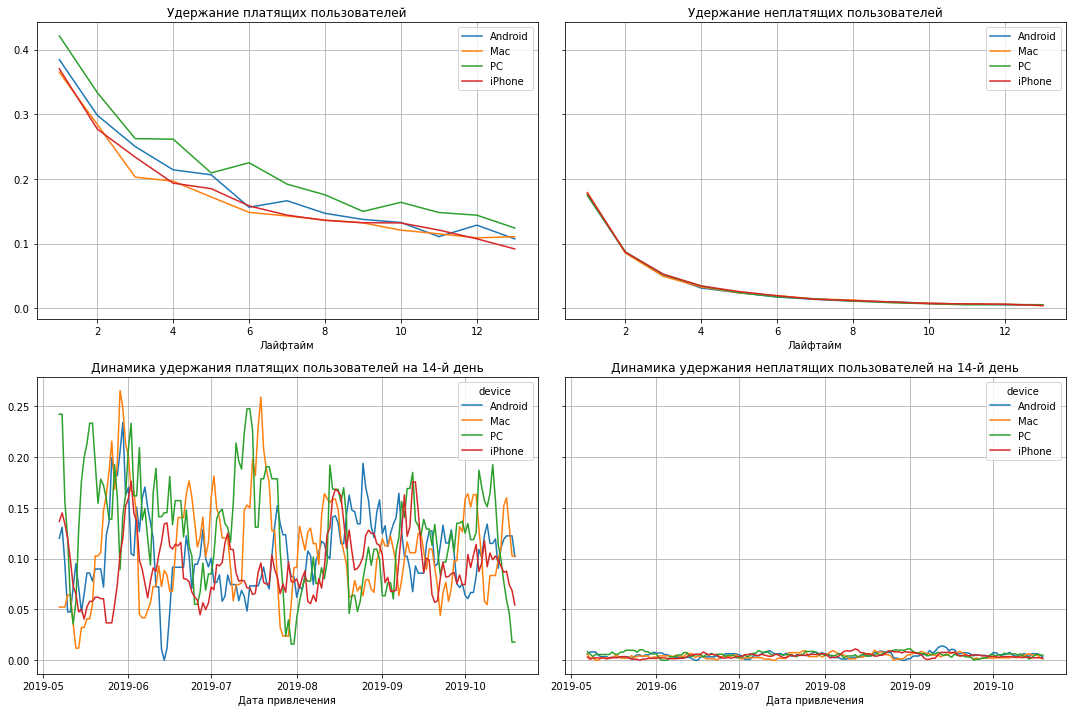

In [46]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод**
- Удержание неплатящих пользователей ниже, чем у платящих.
- Самый высокий коэффициент удержания у пользователей, пользующихся PC.
- На конец рассматриваемого периода самый низкий коэффициент удержания у пользователей, пользующихся iPhone.
- Самый низкий коэффициент удержания (0%) 14-го дня был у пользователей Android в середине июня, самый высокий - у пользователей Mac в конце мая - 25%.

### 5.5 Анализ окупаемости рекламы с разбивкой по странам (конверсия и удержание)

Построим графики динамики конверсии пользователей по странам и динамики конверсии пользователей на 14-й день по странам

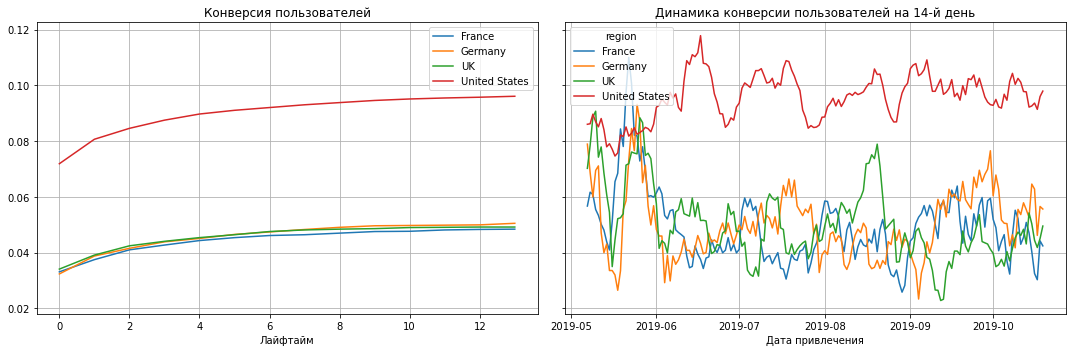

In [47]:
dimensions = ['region']

# смотрим конверсию с разбивкой по странам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод**
- Меньше всего конверсия у пользователей из Франции (почти 5%)
- Больше всего конверсия у пользователей из США (почти 10%)
- Конверсия 14-го дня изменилась по Германии и США. Для пользоватлей из США, привлеченных в начале мая, конверсия была ниже, чем пользователей, привлеченных в конце октября. С пользователями из Германии - наоборот. 
- Пользователи из США не всегда конвертировались лучше немецких. Новые пользователи из других стран, привлеченные в мае, показывали более высокую конверсию.

Построим графики динамики удержания платящих по странам и динамики неплатящих пользователей по странам

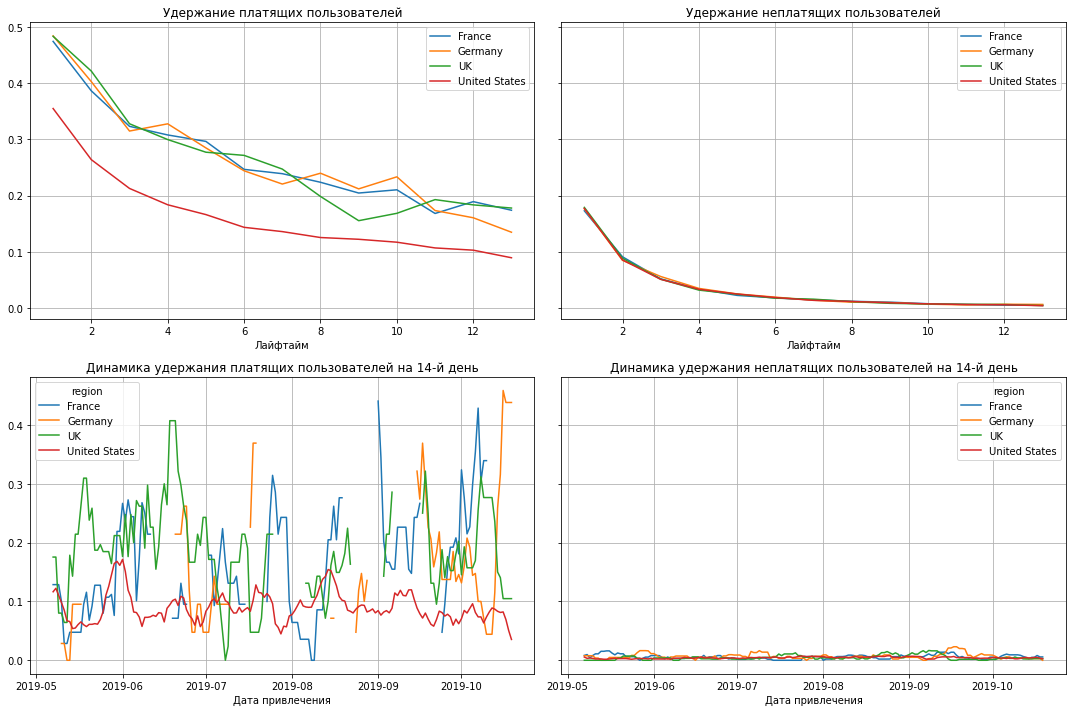

In [48]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод**
- Удержание неплатящих пользователей по всем странам ниже удержания платящих пользователей, что как правило логично.
- Удержание платящих пользователей хуже всего в США (меньше 10%), во Франции и Великобритании удержание пользователей на их 14 день жизни примерно одинаково (19%), в Германии - 13%.
- Удержание 14-го дня платящих пользователей из Германии, привлеченных в конце октября, выше всех остальных.

### 5.6 Анализ окупаемости рекламы по рекламным каналам (конверсия и удержание)

Построим графики динамики конверсии пользователей по каналам привлечения и динамики конверсии пользователей на 14-й день по каналам привлечения

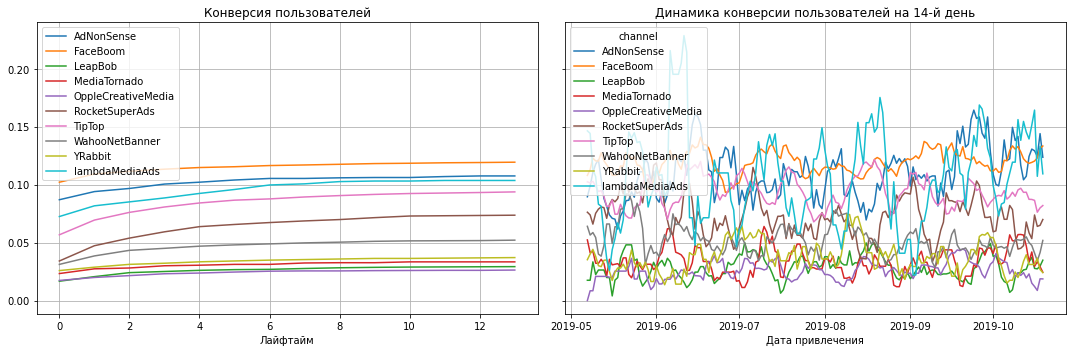

In [49]:
dimensions = ['channel']

# смотрим конверсию с разбивкой по рекламным каналам

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

**Вывод**
- Меньше всего конверсия у пользователей, пришедших через канал OppleCreativeMedia.
- Выше всего конверсия у пользователей, привлеченных через канал FaceBoom.
- Конверсия 14-го дня была выше у пользователей, привлеченных через канал lambdaMediaAds в первой половине июня. 

Построим графики динамики удержания платящих пользователей по каналам привлечения и динамики удержания неплатящих пользователей

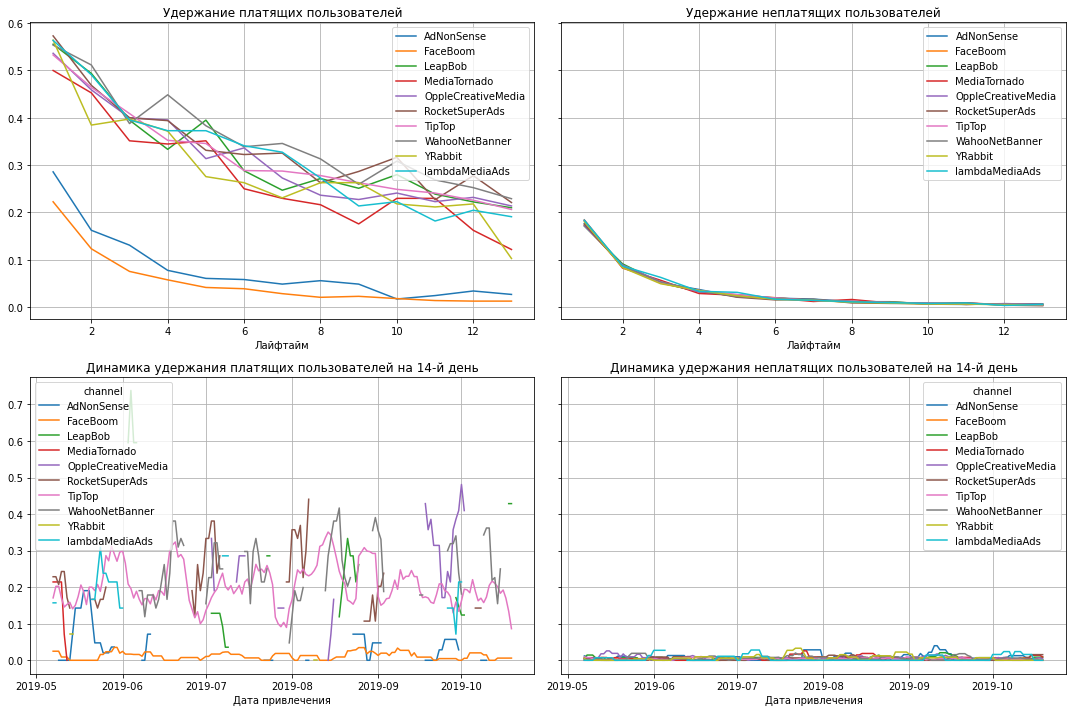

In [50]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions
)

plot_retention(retention_grouped, retention_history, horizon_days)

**Вывод**
- Удержание платящих пользователей, привлеченных через каналы FaceBoom и AdNonSense, схоже с удержанием неплатящих пользователей - удержание по ним значительно ниже удержания платящих пользователей, привлеченных по другим каналам. С каждым днем "жизни" ситуация только хуже. 
- Согласно графику "Динамика удержания платящих пользователей на 14-й день" - по части источников слишком мало трафика/данных и поэтому единично так выскакивают некоторые линии.
- Платящие пользователи, привлеченные по каналу FaceBoom, и неплатящие пользователи стабильно плохо удерживаются.
- Платящие пользователи, привлеченные по каналу LeapBob в начале июня, удерживались на 14-ый день намного лучше остальных.
- Лидера по удержанию пользователей - нет.

<a id="step6"></a>
## 6. Общие выводы

<div style="border-radius: 15px; border: 3px solid Black; padding: 15px;">
<b> Основные моменты:</b>  
    
- Большая часть расходов идет на каналы привлечения потенциальных клиентов под названиями TipTop (52%) и FaceBoom (31%).
- Больше всего в приложение приводит канал привлечения под названием FaceBoom, меньше всего из платных каналов привлечения - OppleCreativeMedia. TipTop - на втором месте. Платных пользователей приходит больше всего из каналов FaceBoom и AdNonSense, TipTop - на втором месте.
- Больше всего платящих пользователей пользуются Mac при использовании данного приложения. Меньше всего - PC.
- Больше всего пользователей приложения (50%) и платящих пользователей из США. Меньше всего пользователей из Германии, однако меньше платящих пользователей - из Франции.
- Расходы на рекламу росли с мая по сентябрь, затем начали снижаться. Рост расходов на рекламу вызван ростом расходов на канал привлечения под названием TipTop.
- Дороже всего стоило привлечения пользователя из TipTop, на втором и третьем месте, в 2 раза дешевле, - FaceBoom и AdNonSense.
- В целом, проект не окупился, т.к. расходы больше доходов. ROI в конце второй недели срока жизни клиента — 80%.
- Реклама через каналы TipTop, FaceBoom и AdNonSense не окупилась за 14 дней срока жизни клиента.
- Несмотря на то, что канал привлечения TipTop занимает 2 место по полученной выручке, расходы по данному каналу привлечения превышают заработанную выручку в разы и растут. Увеличение суммарных расходов в основном вызваны увеличением расходов по данному каналу привлечения.
- Расходы по каналам привлечения FaceBoom и AdNonSense - почти не изменились (2 и 3 место). Занимают 4 и 5 места по привлеченной выручке.
- Реклама через канал lambdaMediaAds окупилась, привлеченная выручка - 1 место.
- Реклама через канал YRabbit - окупилась лучше всех на 2 день жизни клиента, однако выручка по данному каналу - на 6 месте. Окупаемость на 1 месте, т.к. расходы по данному каналу одни из самых минимальных.
- Реклама в США не окупилась за 14 дней срока жизни клиента, несмотря на то, что именно пользователи из США приносят большую выручку, т.к. расходы существенно выше выручки.
- Расходы на рекламу выросли только по пользователям из США, по всем остальным странам они уменьшились в июне и оставались в дальнейшем неизменными.
- Меньше всего конверсия у пользователей, пользующихся PC, выше всего - Mac. Удержание пользователей по всем устройствам падает, однако на PC  выше всего коэффициент удержания.
- Меньше всего конверсия по пользователям из Франции, выше всего - из США, однако коэфффициент удержания меньше всего по пользователям из США.
- Меньше всего конверсия по каналам OppleCreativeMedia. Больше всего - FaceBoom, AdNonSense, lambdaMediaAds. Коэффициент удержания меньше всего у FaceBoom и AdNonSense.

<div style="border-radius: 15px; border: 3px solid Black; padding: 15px;">
<b> Основные причины неэффективности привлечения пользователей:</b>  
    
- Нерациональная трата средств на канал TipTop, т.к. по нему расходы значительно превышают доходы, а конверсия - не самая высокая.
- Нерациональная трата средств на привлечение пользователей из США (на канал TipTop), т.к. расходы значительно превышают доходы. 
- Неудобство приложения на PC, т.к. конверсия меньше всех и платящих пользователей там меньше всех.

<div style="border-radius: 15px; border: 3px solid Black; padding: 15px;">
<b> Рекомендации для отдела маркетинга для повышения эффективности:</b>  
    
- Возможно, стоит рассмотреть приложение на PC. Поскольку там низкая конверсия и пользователей, пользующихся этим приложением, меньше всего, то стоит рассмотреть изменение приложения на PC, т.к. оно не очень удобно.
- Возможно стоит обратить внимание (вливать больше денежных средств) на такой канал как lambdaMediaAds, т.к. по данному каналу привлекают больше всего выручки, он окупается и конверсия по ниму - топ 3. 
- Стоит обратить внимание на пользователей из США, т.к. там хуже всего удерживаются пользователи. Возможно, стоит обратить внимания на контент, который представлен в приложении. Скорее всего он не очень нравится пользователям из США. Стоит проанализировать их интересы. 
- Стоит пересмотреть чрезмерные траты на привлечение пользователей из США, возможно, стоит  выбрать другой источник привлечения пользователей из США, которые менее затратны. Напрмер, на канал RocketSuperAds, который окупается в США и при этом занимается 2 место по доходам (первый - TipTop) при уменьшении доходов.
- Стоит рассмотреть рассходы на канал TipTop. Имеет смысл их уменьшить, т.к. отдача от канала намного меньше и он не окупается. 